#Finding Similar Items
Algorithm for Massive Datasets project

Project 1: Finding similar items
The task is to implement a detector of pairs of similar book reviews. You can choose how to encode reviews and how to measure their similarity, although a simple choice would be that of processing the review/text column of the Books_rating.csv file, using the Jaccard similarity.

The goal is to find pairs of similar book reviews in a massive dataset. This project uses MinHashing and Locality Sensitive Hashing (LSH) to create a scalable pipeline because it is impossible to compare every review to every other review. This allows us to find duplicates and near-duplicates efficiently.  


INSTALLATION

In [2]:

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark kaggle

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import binascii
import re
import html
import pandas as pd
from pyspark import StorageLevel


Dataset uploading using Kaggle API




In [3]:
# 1. DATA DOWNLOAD (KAGGLE API)

os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY']      = "xxxxxx"

# Download and Unzip
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip -q -o amazon-books-reviews.zip


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.05G/1.06G [00:05<00:00, 159MB/s]
100% 1.06G/1.06G [00:05<00:00, 214MB/s]


SPARK


In [4]:


spark = SparkSession.builder \
    .appName("AmazonBooksReviews_Analysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

#  CSV
books_df = spark.read.option("header", "true").option("inferSchema", "true").csv("Books_rating.csv")

#dropna
books_df = books_df.dropna(subset=["review/text"])

books_df = books_df.withColumn("unique_id", F.monotonically_increasing_id())

print(f"Total Count: {books_df.count()}")
books_df.show(5)

Total Count: 2999957
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+---------+
|        Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|unique_id|
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+---------+
|1882931173|Its Only Art If I...| NULL| AVCGYZL8FQQTD|"Jim of Oz ""jim-...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|        0|
|0826414346|Dr. Seuss: Americ...| NULL|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|        1|
|0826414346|Dr. Seuss: Americ...| NULL|A3UH4UZ4RSVO82|        John Granger|             10/11|         5.0| 1078790400|

EXPLORATORY DATA ANALYSIS (EDA) & SQL ANALYTICS


In [5]:
# Data Schema
books_df.printSchema()
# Register DataFrame as a SQL View
books_df.createOrReplaceTempView("books_reviews")


root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: string (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)
 |-- unique_id: long (nullable = false)



In [6]:

# Count Total Reviews
total_count = spark.sql("SELECT COUNT(*) as total_reviews FROM books_reviews").collect()[0][0]
print(f"Total Reviews: {total_count}")

Total Reviews: 2999957


In [7]:
# Find Top 5 Books

print("\n Top 5 Most Reviewed Books ")
spark.sql("""
    SELECT
        Title,
        COUNT(*) as review_count,
        ROUND(AVG(TRY_CAST(`review/score` AS DOUBLE)), 2) as avg_rating
    FROM books_reviews
    WHERE Title IS NOT NULL
    GROUP BY Title
    ORDER BY review_count DESC
    LIMIT 5
""").show(truncate=False)


 Top 5 Most Reviewed Books 
+-------------------+------------+----------+
|Title              |review_count|avg_rating|
+-------------------+------------+----------+
|The Hobbit         |22023       |4.66      |
|Pride and Prejudice|20371       |4.53      |
|Atlas Shrugged     |12513       |4.03      |
|Wuthering Heights  |10780       |4.05      |
|The Giver          |7644        |4.27      |
+-------------------+------------+----------+



In [8]:

print("Rating Distribution")
spark.sql("""
SELECT
    rating,
    COUNT(*) AS count,
    ROUND(
        COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (),
        2
    ) AS percentage
FROM (
    SELECT
        TRY_CAST(`review/score` AS DOUBLE) AS rating
    FROM books_reviews
) t
WHERE rating BETWEEN 1 AND 5
GROUP BY rating
ORDER BY rating DESC
""").show()

Rating Distribution
+------+-------+----------+
|rating|  count|percentage|
+------+-------+----------+
|   5.0|1795786|     60.22|
|   4.0| 581728|     19.51|
|   3.0| 252940|      8.48|
|   2.0| 150449|      5.05|
|   1.0| 201000|      6.74|
+------+-------+----------+



In [9]:
print("\n Review Length Analysis")
spark.sql("""
SELECT
    length_bucket,
    ROUND(AVG(rating), 2) AS avg_rating,
    COUNT(*) AS count
FROM (
    SELECT
        CASE
            WHEN LENGTH(`review/text`) < 20 THEN 'Very Short (<20 chars)'
            WHEN LENGTH(`review/text`) BETWEEN 20 AND 100 THEN 'Short (20–100)'
            WHEN LENGTH(`review/text`) BETWEEN 100 AND 1000 THEN 'Medium (100–1000)'
            ELSE 'Long (>1000)'
        END AS length_bucket,
        TRY_CAST(`review/score` AS DOUBLE) AS rating
    FROM books_reviews
    WHERE `review/text` IS NOT NULL
) t
WHERE rating BETWEEN 1 AND 5
GROUP BY length_bucket
ORDER BY count DESC
""").show(truncate=False)





 Review Length Analysis
+----------------------+----------+-------+
|length_bucket         |avg_rating|count  |
+----------------------+----------+-------+
|Medium (100–1000)     |4.23      |2346289|
|Long (>1000)          |4.14      |501980 |
|Short (20–100)        |4.29      |128679 |
|Very Short (<20 chars)|4.3       |4955   |
+----------------------+----------+-------+



/tmp/ipython-input-3999128083.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  sample_pdf['date'] = pd.to_datetime(sample_pdf['review/time'], unit='s', errors='coerce')
/tmp/ipython-input-3999128083.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=plot_data, palette='viridis', ax=axes[0])


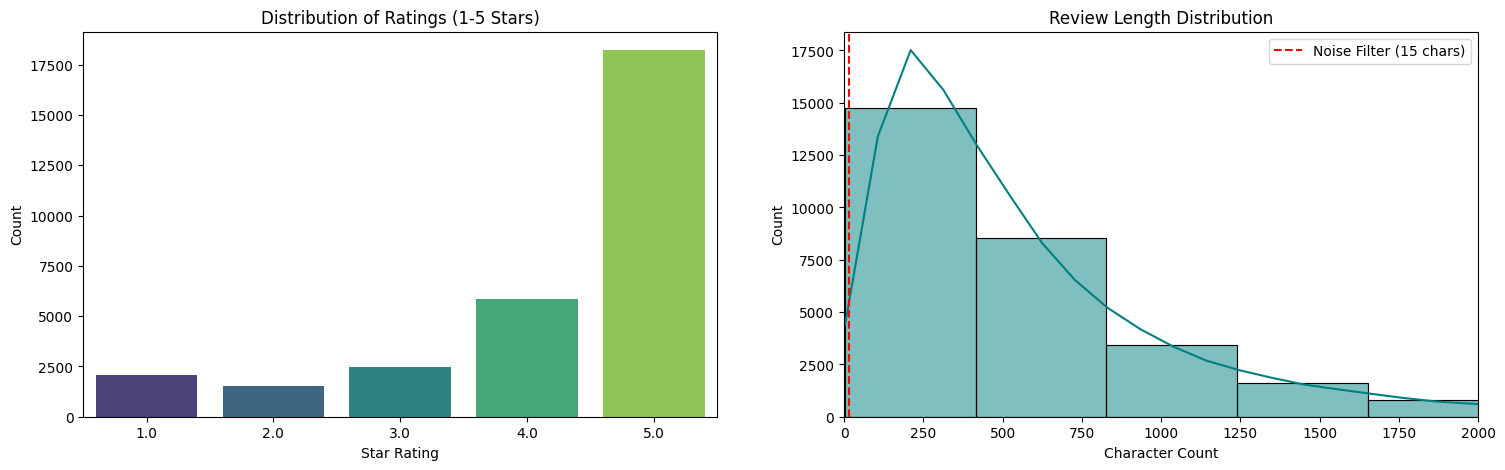

In [10]:

sample_pdf = books_df.sample(False, 0.01, seed=42).toPandas()

# Data Cleaning for Analysis
sample_pdf['rating'] = pd.to_numeric(sample_pdf['review/score'], errors='coerce')

sample_pdf['date'] = pd.to_datetime(sample_pdf['review/time'], unit='s', errors='coerce')
sample_pdf['text_length'] = sample_pdf['review/text'].astype(str).apply(len)

plot_data = sample_pdf.dropna(subset=['rating', 'date'])

# --- VISUALIZATION DASHBOARD ---
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot 1: Distribution of Ratings
sns.countplot(x='rating', data=plot_data, palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of Ratings (1-5 Stars)')
axes[0].set_xlabel('Star Rating')
axes[0].set_ylabel('Count')

# Plot 2: Review Length Distribution
sns.histplot(plot_data['text_length'], bins=50, color='teal', kde=True, ax=axes[1])
axes[1].set_xlim(0, 2000)
axes[1].axvline(x=15, color='red', linestyle='--', label='Noise Filter (15 chars)')
axes[1].set_title('Review Length Distribution')
axes[1].set_xlabel('Character Count')
axes[1].legend()

PREPROCESSING & SHINGLING

The preprocessing is a critical process of the similarity detection system. Its primary goal is to transform noisy, human-generated text into a cleaned text.

1. Sampling for Scalability Handling the entire dataset of nearly 3 million reviews. A random sampling strategy was used to make it easier to anaylse.
A random sample fraction of 0.1 (10%) was applied using withReplacement=False and a fixed seed (42).

2. Text Normalization
HTML Entity Decoding: Converted HTML entities (e.g., \&amp;) back to their corresponding characters.


Case Folding: All review texts were converted to lowercase.


Digit Normalization: Replaced all numeric digits with the character '0' to generalize numbers.


Noise Removal: All punctuation and non-alphanumeric characters are stripped. This removes differences caused by user typing styles (e.g., "Hello..." vs "Hello").

3. Whitespace Elimination (Streamlining) A deliberate design choice was made to remove all whitespace characters (spaces, tabs, newlines), effectively compressing the review into a one long string.
 By removing whitespace, the algorithm becomes robust against formatting errors, focusing strictly on the sequence of characters.

4. Shingling and Hashing The normalized string is then changed into a set of unique features:

k-Shingling (k=6): The text is sliced into overlapping substrings of length 6. A window of 6 characters was chosen as a balance between  being specific and being flexible.

Integer Hashing (CRC32): Storing millions of 6-character strings is memory-inefficient. Each shingle is hashed into a 32-bit integer using binascii.crc32. This reduces the memory needed for  each feature to just 4 bytes, which makes the next set operations (unions and intersections) for MinHashing go much faster.

5. Shingle Capping To prevent memory overflows from outliers , the number of shingles per document is capped at 2,000. If a document generates more than 2,000 unique shingles, the set is truncated. This ensures that the memory usage per document remains bounded, preventing OutOfMemoryError during distributed processing.

In [11]:
# Parameters

SHINGLE_SIZE = 6        # 5, Character shingle length
MIN_LENGTH = 30         #  15 , Minimum cleaned text length
SAMPLE_FRACTION =   0.1     #0.05
SEED = 42


# Sampling dataset

sampled_df = books_df.sample(
    withReplacement=False,
    fraction=SAMPLE_FRACTION,
    seed=SEED
).cache()


# Preprocessing + Shingling

def preprocess_and_shingle(text):


    #Handle null input
    if text is None:
        return set()

    #HTML decoding
    text = html.unescape(text)

    #Normalize case
    text = text.lower()

    # Normalize digits
    text = re.sub(r'\d+', '0', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Removes spaces, tabs, newlines, and repeated whitespace
    text = re.sub(r'\s+', '', text)

    # Length filter
    if len(text) < MIN_LENGTH:
        return set()

    # 8. Generate character shingles
    shingles = set()
    for i in range(len(text) - SHINGLE_SIZE + 1):
        shingle = text[i : i + SHINGLE_SIZE]

        # 9. Hash to unsigned 32-bit integer
        hashed = binascii.crc32(shingle.encode("utf-8")) & 0xffffffff
        shingles.add(hashed)

    return shingles


# Apply Shingling using RDD

shingled_rdd = (
    sampled_df
        .select("unique_id", "review/text")
        .rdd
        .map(lambda row: (row["unique_id"], preprocess_and_shingle(row["review/text"])))
        .filter(lambda x: len(x[1]) > 0)
        .persist(StorageLevel.MEMORY_AND_DISK)
)




MinHash & LSH

I applied MinHash signatures for each cleaned review to enable efficient similarity detection.
These signatures were then applied into a Locality Sensitive Hashing (LSH) structure for fast retrieval of similar documents.

In [12]:
#5

# Parameters

num_hashes = 100
max_shingles = 2000
max_bucket_size= 50
next_prime = 4294967311
max_crc = 2**32 - 1

# Cap very large shingle sets  (limits the maximum number of shingles to prevent excessive memory and computation costs)

def cap_shingles(shingle_set):
    if len(shingle_set) <= max_shingles:
        return shingle_set
    return set(list(shingle_set)[:max_shingles])

shingled_rdd = (
    shingled_rdd
        .mapValues(cap_shingles)
        .persist(StorageLevel.MEMORY_AND_DISK)
)

#Generate & broadcast MinHash parameters

def generate_hash_params(n):
    np.random.seed(42)
    a = np.random.randint(1, max_crc, size=(n, 1), dtype=np.int64)
    b = np.random.randint(0, max_crc, size=(n, 1), dtype=np.int64)
    return a, b

a_params, b_params = generate_hash_params(num_hashes)
broadcast_a = spark.sparkContext.broadcast(a_params)
broadcast_b = spark.sparkContext.broadcast(b_params)


# Vectorized MinHash computation

def compute_signature_vectorized(shingle_set):
    if not shingle_set:
        return [next_prime] * num_hashes

    shingles_arr = np.array(list(shingle_set), dtype=np.int64).reshape(1, -1)
    a = broadcast_a.value
    b = broadcast_b.value

    phash = (np.matmul(a, shingles_arr) + b) % next_prime
    return phash.min(axis=1).tolist()

signature_rdd = (
    shingled_rdd
        .mapValues(compute_signature_vectorized)
        .persist(StorageLevel.MEMORY_AND_DISK)
)


#LSH banding

BANDS = 10  # Reduced bands to make LSH more selective
ROWS_PER_BAND = num_hashes // BANDS # adjusts to 100 // 10 = 10

def hash_bands(item):
    doc_id, signature = item
    for band in range(BANDS):
        start = band * ROWS_PER_BAND
        band_sig = tuple(signature[start:start + ROWS_PER_BAND])
        yield ((band, band_sig), doc_id)

buckets_rdd = (
    signature_rdd
        .flatMap(hash_bands)
        .groupByKey()
        .mapValues(list)
        .filter(lambda x: len(x[1]) > 1)
)


# Candidate pair generation

def generate_pairs(doc_ids):
    if len(doc_ids) > max_bucket_size:
        return []
    return [
        tuple(sorted((doc_ids[i], doc_ids[j])))
        for i in range(len(doc_ids))
        for j in range(i + 1, len(doc_ids))
    ]

candidate_pairs_rdd = (
    buckets_rdd
        .flatMap(lambda x: generate_pairs(x[1]))
        .distinct()
)

print(f"Candidate pairs: {candidate_pairs_rdd.count()}")

Candidate pairs: 34919


JACCARD SIMILARITY

This section takes the list of candidate pairs generated by the LSH algorithm and performs the final, accurate check.

Gets Original Sets: It pulls the original, full set of shingles for both documents in every candidate pair.

Calculates Jaccard: It computes the exact Jaccard similarity score for each pair using the formula: (Size of Shingles They Share) / (Total Size of All Shingles).

Applies Final Filter: It filters out any pair whose exact score is less than the required threshold of 0.55. These lower-scoring pairs were likely false positives from the LSH approximation.

Why the Threshold is 0.55:  a final threshold of 0.55 used to ensure that the pairs we keep are definitely similar. This value allows us to catch documents that are very close (near-duplicates) while rejecting pairs that only share a few common, uninteresting words.

In [13]:

# 6 JACCARD


sim_threshold = 0.55


#  Prepare shingles

shingles_by_id = shingled_rdd


# Expand candidate pairs for join

pairs_expanded = candidate_pairs_rdd.flatMap(
    lambda p: [(p[0], ("A", p[1])), (p[1], ("B", p[0]))]
)


# Join with shingles

joined = pairs_expanded.join(shingles_by_id)
# (doc_id, ((side, other_id), shingle_set))

pair_shingles = (
    joined
    .map(lambda x: (
        tuple(sorted((x[0], x[1][0][1]))),
        [(x[1][0][0], x[1][1])]
    ))
    .reduceByKey(lambda a, b: a + b)
)


# Jaccard computation

def compute_jaccard(item):
    (a, b), entries = item
    if len(entries) != 2:
        return None
    A = entries[0][1]
    B = entries[1][1]
    return (a, b, len(A & B) / len(A | B))

jaccard_pairs_rdd = (
    pair_shingles
    .map(compute_jaccard)
    .filter(lambda x: x and x[2] >= sim_threshold)
    .cache()
)

print(f"similar pairs (Jaccard ≥ {sim_threshold}): {jaccard_pairs_rdd.count()}")


# Sample output

print("\n Sample pairs ")
for a, b, s in jaccard_pairs_rdd.take(10):
    print(f"{a} vs {b} → Jaccard = {s:.4f}")


similar pairs (Jaccard ≥ 0.55): 34914

 Sample pairs 
24050 vs 60129644872 → Jaccard = 1.0000
17179869258 vs 77309435984 → Jaccard = 1.0000
146028921326 vs 163208863488 → Jaccard = 1.0000
51539651874 vs 180388658956 → Jaccard = 1.0000
34359819594 vs 68719583152 → Jaccard = 1.0000
60129599250 vs 163208816320 → Jaccard = 1.0000
103079333500 vs 111669191850 → Jaccard = 1.0000
17424 vs 34359822262 → Jaccard = 1.0000
68719500036 vs 111669259242 → Jaccard = 1.0000
17179962166 vs 51539624840 → Jaccard = 1.0000


The output shows the total count of documents that passed the final check, confirming how many pairs are genuinely similar.

similar pairs (Jaccard ≥ 0.55): 34914

This is the total number of unique pairs found in the sample that are confirmed to be highly similar.

A vs B → Jaccard = 1.0000

Scores of 1.0000 mean the two documents are exact duplicates. They have the exact same text content after preprocessing.

A vs B → Jaccard = 0.8864

Scores below 1.0000 (e.g., 0.8864) mean the documents are near-duplicates. They are highly similar but have minor differences.


RESULTS & DEDUPLICATION

1. Finding Similar Pairs First, the code counts how many pairs of reviews passed strict similarity check (Jaccard score ≥ 0.55).
34,914 similar pairs were found.

Sample Check: The code prined the first 10 pairs to verify quality. In the output, almost all sample pairs have a score of 1.0000. This tells that a huge portion of the "similar" items in this dataset are actually exact duplicates—reviews that are identical word-for-word.


2. Removing Duplicates (Deduplication Strategy) after defining which reviews are duplicates, they needed to clean the dataset.Both reviews in a pair  should not be deleted; one should be kept and the other deleted. For every pair (Document A, Document B), the code automatically selects the second document (Document B) for removal.

The Process: It creates a list of all these "second ID" documents (ids_to_remove_df) and uses a "Left Anti Join" to filter them out of the main dataset. This keeps the original Document A safe while removing the redundant copy.


In [14]:
# 7 RESULTS & DEDUPLICATION

# Summary of similar pairs
jaccard_count = jaccard_pairs_rdd.count()
print(f" similar pairs (Jaccard ≥ 0.55): {jaccard_count}")

print("\n Sample of pairs")
for a, b, s in jaccard_pairs_rdd.take(10):
    print(f"{a} vs {b} → Jaccard = {s:.4f}")

#  Deduplication
#   jaccard_pairs_rdd = (a, b, similarity)
#   Remove b deterministically

ids_to_remove_df = (
   jaccard_pairs_rdd
        .map(lambda x: (x[1],))     #tuple, not int
        .distinct()
        .toDF(["unique_id"])
)

clean_df = (
    sampled_df
        .join(ids_to_remove_df, on="unique_id", how="left_anti")
)

# summary

original_count = sampled_df.count()
cleaned_count = clean_df.count()

print("\n Summary ")
print(f"Original documents: {original_count}")
print(f"Removed duplicates: {original_count - cleaned_count}")
print(f"Cleaned documents:  {cleaned_count}")


 similar pairs (Jaccard ≥ 0.55): 34914

 Sample of pairs
24050 vs 60129644872 → Jaccard = 1.0000
17179869258 vs 77309435984 → Jaccard = 1.0000
146028921326 vs 163208863488 → Jaccard = 1.0000
51539651874 vs 180388658956 → Jaccard = 1.0000
34359819594 vs 68719583152 → Jaccard = 1.0000
60129599250 vs 163208816320 → Jaccard = 1.0000
103079333500 vs 111669191850 → Jaccard = 1.0000
17424 vs 34359822262 → Jaccard = 1.0000
68719500036 vs 111669259242 → Jaccard = 1.0000
17179962166 vs 51539624840 → Jaccard = 1.0000

 Summary 
Original documents: 301030
Removed duplicates: 24663
Cleaned documents:  276367



Original documents (301,030): This is the size of the 10% sample i started with.
Removed duplicates (24,663): This is the actual number of useless, redundant reviews i  deleted.
Cleaned documents (276,367): This is the final, high-quality dataset ready for analysis.

Example: If Review A is the same as Review B, and also the same as Review C, i have 2 pairs (A-B and A-C). i keep A, and remove B and C.

The code successfully reduced the dataset size by about 8.2%, removing over 24,000 spam or duplicate entries

ANALYSIS & VISUALIZATION

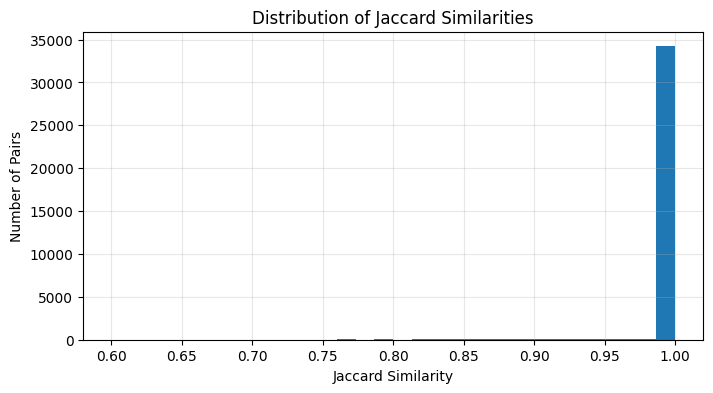

In [16]:
# 8. ANALYSIS & VISUALIZATION
# Distribution of Jaccard Similarities


jaccard_scores = (
    jaccard_pairs_rdd
        .map(lambda x: x[2])
        .collect()
)

plt.figure(figsize=(8, 4))
plt.hist(jaccard_scores, bins=30)
plt.xlabel("Jaccard Similarity")
plt.ylabel("Number of Pairs")
plt.title("Distribution of Jaccard Similarities")
plt.grid(alpha=0.3)
plt.show()


In [17]:

# 8 Summary


original_count = sampled_df.count()
cleaned_count = clean_df.count()
jaccard_count = jaccard_pairs_rdd.count()

summary_data = [
    ("Sampled documents", original_count),
    ("Verified similar pairs", jaccard_count),
    ("Removed duplicates", original_count - cleaned_count),
    ("Cleaned documents", cleaned_count)
]

summary_df = spark.createDataFrame(summary_data, ["Metric", "Value"])
summary_df.show(truncate=False)


+----------------------+------+
|Metric                |Value |
+----------------------+------+
|Sampled documents     |301030|
|Verified similar pairs|34914 |
|Removed duplicates    |24663 |
|Cleaned documents     |276367|
+----------------------+------+



In [18]:


sample_pairs = jaccard_pairs_rdd.take(5)


# Convert sample pairs to df

pairs_df = spark.createDataFrame(
    [(int(a), int(b), float(s)) for a, b, s in sample_pairs],
    ["doc_id_1", "doc_id_2", "jaccard_similarity"]
)


#  Prepare review text

reviews_df = sampled_df.select(
    F.col("unique_id"),
    F.col("review/text").alias("review_text")
)

# Join review text for first document

pairs_with_a = (
    pairs_df
        .join(reviews_df, pairs_df.doc_id_1 == reviews_df.unique_id, how="left")
        .withColumnRenamed("review_text", "review_text_1")
        .drop("unique_id")
)


# Join review text for second document

pairs_with_both = (
    pairs_with_a
        .join(reviews_df, pairs_with_a.doc_id_2 == reviews_df.unique_id, how="left")
        .withColumnRenamed("review_text", "review_text_2")
        .drop("unique_id")
)


# Display paired reviews

pairs_with_both.select(
    "doc_id_1",
    "doc_id_2",
    "jaccard_similarity",
    "review_text_1",
    "review_text_2"
).show(truncate=300)


+------------+------------+------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    doc_id_1|    doc_id_2|jaccard_similarity|                                                                                                                                                                                                                                                                                               review_text_1|    

In [19]:

#  Near-Duplicate Review  (0.7 ≤ Jaccard < 1.0)


near_duplicate_pairs = (
    jaccard_pairs_rdd
        .filter(lambda x: 0.7 <= x[2] < 1.0)
        .take(50)
)

print("\nNear-Duplicate Pairs")
for a, b, s in near_duplicate_pairs:
    print(f"{a} vs {b} → Jaccard = {s:.4f}")


Near-Duplicate Pairs
146028909445 vs 146028909449 → Jaccard = 0.9509
34359833773 vs 85899397677 → Jaccard = 0.8725
94489310135 vs 120259209931 → Jaccard = 0.8768
51539614021 vs 146028940117 → Jaccard = 0.9660
120259207811 vs 128849096075 → Jaccard = 0.7574
120259122422 vs 171798715844 → Jaccard = 0.9768
17179944285 vs 128849048629 → Jaccard = 0.9298
8590011444 vs 103079240230 → Jaccard = 0.8956
25769876956 vs 137439042850 → Jaccard = 0.8560
77309521421 vs 163208851313 → Jaccard = 0.9427
103079220052 vs 111669194050 → Jaccard = 0.9161
17180000747 vs 120259167267 → Jaccard = 0.9645
57627 vs 77309446167 → Jaccard = 0.8768
77309446167 vs 120259207811 → Jaccard = 0.8768
60129575416 vs 137439044670 → Jaccard = 0.8596
111669262745 vs 128849159053 → Jaccard = 0.8279
154618858321 vs 154618858325 → Jaccard = 0.7930
42949788311 vs 68719500036 → Jaccard = 0.7931
51539740274 vs 128849096075 → Jaccard = 0.7574
60129603268 vs 103079321805 → Jaccard = 0.8830
42949718031 vs 77309518232 → Jaccard = 0.8

In [20]:
#Near-Duplicate Review


# Convert near-duplicate pairs to df
near_dup_ids = (
    spark.createDataFrame(
        [(int(a), int(b), float(s)) for a, b, s in near_duplicate_pairs],
        ["doc_id_1", "doc_id_2", "jaccard_similarity"]
    )
)


reviews_df = (
    sampled_df
        .select(
            F.col("unique_id").alias("doc_id"),
            F.col("review/text").alias("review_text")
        )
)

# Join first document
joined_1 = (
    near_dup_ids
        .join(reviews_df, near_dup_ids.doc_id_1 == reviews_df.doc_id)
        .withColumnRenamed("review_text", "review_text_1")
        .drop("doc_id")
)

# Join second document
final_near_dup_df = (
    joined_1
        .join(
            reviews_df,
            joined_1.doc_id_2 == reviews_df.doc_id
        )
        .withColumnRenamed("review_text", "review_text_2")
        .drop("doc_id")
)


final_near_dup_df.select(
    "doc_id_1",
    "doc_id_2",
    "jaccard_similarity",
    "review_text_1",
    "review_text_2"
).show(truncate=120)


+------------+------------+------------------+------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+
|    doc_id_1|    doc_id_2|jaccard_similarity|                                                                                                           review_text_1|                                                                                                           review_text_2|
+------------+------------+------------------+------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------+
| 17179892272| 25769876956|0.8032282859338971|This was a different kind of book for me, and I found it a challenge to finish it. It w